# 01: The Pre-Transformer Era

Before transformers revolutionized NLP in 2017, researchers used **Recurrent Neural Networks (RNNs)** and their variants to process sequences. Understanding these earlier architectures helps you appreciate why transformers were such a breakthrough.

## What You'll Learn

1. **Why sequence modeling is challenging** - The core problems we need to solve
2. **Vanilla RNNs** - The basic idea and implementation from scratch
3. **The vanishing gradient problem** - Why RNNs struggle with long sequences
4. **LSTMs** - Solutions that improved things (but weren't perfect)
5. **Seq2seq models** - How RNNs were used for translation and generation
6. **Limitations** - What problems remained unsolved, motivating transformers

By the end, you'll understand exactly **why** the AI community needed transformers.

**Learning approach**: We'll explain everything in simple terms first, then dive into the math and code!

In [2]:
# Setup - Import all the libraries we'll need
import sys
import os
import numpy as np              # For numerical operations and arrays
import matplotlib.pyplot as plt # For creating plots and visualizations
import seaborn as sns          # For making beautiful heatmaps
from IPython.display import HTML

# Add our custom utilities folder to the path so we can import helper functions
sys.path.append(os.path.abspath('../src'))
from utils import set_style, print_tensor_info

# Set consistent visual style for all our plots
set_style()

# Set random seed for reproducibility (same random numbers each time)
np.random.seed(42)

print("✓ Setup complete! Ready to learn about RNNs.")

✓ Setup complete! Ready to learn about RNNs.


## Part 1: Why Sequence Modeling is Hard

Many real-world problems involve **sequences** where **order matters**. Let's understand why this is challenging.

### Examples of Sequential Data

Think about these examples where changing the order completely changes the meaning:

- **Text**: 
  - "dog bites man" (common occurrence) 
  - "man bites dog" (newsworthy event!) 
  - Same words, completely different meanings!
  
- **Speech**: Sound waves that unfold over time
  - Saying "hello" vs "olleh" - order matters!
  
- **Time series**: Stock prices, weather data
  - Today's temperature depends on yesterday's
  
- **DNA**: Genetic sequences
  - ATGC in different order = different protein
  
- **Video**: Frames in temporal order
  - Frame 100 depends on what happened in frame 99

### The Challenge with Traditional Neural Networks

Traditional feedforward neural networks (the kind you might have learned first) have three big problems with sequences:

#### Problem 1: Fixed Input Size
```
Regular neural network:
  Input layer: [x1, x2, x3] → Hidden → Output
  
❌ Always expects exactly 3 inputs!
❌ Can't handle "The cat sat" (3 words) AND "The cat sat on the mat" (6 words)
```

#### Problem 2: No Memory
```
Each input is processed independently:
  Process "The" → forget everything
  Process "cat" → forget everything  
  Process "sat" → forget everything
  
❌ The network doesn't "remember" it saw "The" when processing "cat"!
```

#### Problem 3: No Temporal Structure
```
Position information is lost:
  ["cat", "dog", "mouse"] looks the same as ["dog", "mouse", "cat"]
  
❌ The network doesn't know "cat" came before "dog"!
```

### What We Really Need

An ideal sequence model should:
1. ✓ **Process variable-length inputs** (handle any sequence length)
2. ✓ **Remember previous inputs** (have some kind of memory)
3. ✓ **Understand temporal/positional relationships** (know what comes before what)

**RNNs were the first successful attempt at solving these problems!**

## Part 2: Recurrent Neural Networks (RNNs)

### The Big Idea (Simple Explanation)

Imagine reading a book:
- You read word 1 → you **remember** what it was
- You read word 2 → you **remember** words 1 and 2
- You read word 3 → you **remember** the story so far
- And so on...

**Your brain maintains a "summary" of everything you've read so far. This is exactly what RNNs do!**

### How RNNs Work

RNNs process sequences **one element at a time**, maintaining a **hidden state** that acts as **memory**.

```
Think of it like this:
  
  You (the RNN) have a notepad (hidden state)
  
  Step 1: Read "The"     → update your notepad with: "saw 'The'"
  Step 2: Read "cat"     → update your notepad with: "saw 'The cat'"
  Step 3: Read "sat"     → update your notepad with: "saw 'The cat sat'"
  
  Your notepad = hidden state h_t
  The word you read = input x_t
  What you write next = output y_t
```

### The RNN Equations (Detailed Explanation)

At each timestep `t`, an RNN does two things:

#### Equation 1: Update the hidden state (the "memory")

```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
```

**Let's break this down piece by piece:**

1. **`h_{t-1}`** - The previous hidden state (what we remembered from before)
   - Think: "My notepad from the last word"
   
2. **`x_t`** - The current input (the word we're reading now)
   - Think: "The new word I just saw"
   
3. **`W_hh * h_{t-1}`** - Transform the previous memory
   - `W_hh` is a weight matrix (learned during training)
   - This says: "take my old notes and adjust them"
   - `W_hh` = "hidden-to-hidden" weights
   
4. **`W_xh * x_t`** - Transform the current input
   - `W_xh` is another weight matrix (also learned)
   - This says: "process the new word I just read"
   - `W_xh` = "input-to-hidden" weights
   
5. **`W_hh * h_{t-1} + W_xh * x_t`** - Combine old memory with new input
   - Think: "Mix my old notes with the new word"
   
6. **`+ b_h`** - Add a bias (a learned offset)
   - Small adjustment to help the model learn better
   
7. **`tanh(...)`** - Apply activation function
   - Squashes values to be between -1 and 1
   - Adds non-linearity (makes the model more powerful)
   - Think: "Clean up my notes to a standard format"
   
8. **`h_t`** - The new hidden state (updated memory)
   - Think: "My updated notepad with all info so far"

#### Equation 2: Generate output (optional, for predictions)

```
y_t = W_hy * h_t + b_y
```

**Breaking it down:**

1. **`h_t`** - Our current memory/notepad
2. **`W_hy * h_t`** - Transform memory to output space
   - `W_hy` = "hidden-to-output" weights
   - Think: "Based on my notes, what should I predict?"
3. **`+ b_y`** - Add bias
4. **`y_t`** - The output (could be next word prediction, classification, etc.)

### Visual Representation

```
Time:     t=0           t=1           t=2           t=3

Input:    "The"        "cat"         "sat"         "down"
           ↓             ↓             ↓             ↓
        [RNN cell]   [RNN cell]   [RNN cell]   [RNN cell]
           ↓             ↓             ↓             ↓
Hidden:   h_0 ------→  h_1 ------→  h_2 ------→  h_3
           ↓             ↓             ↓             ↓
Output:   y_0          y_1           y_2           y_3
       (prediction) (prediction)  (prediction)  (prediction)
```

**Key insight**: The arrows between h_0 → h_1 → h_2 → h_3 show how information flows through time!

### Three Important Properties

1. **Same weights shared across all timesteps**
   - `W_hh`, `W_xh`, `W_hy` are the same whether processing word 1 or word 100
   - This is called "parameter sharing" - makes the model efficient!
   - Think: You use the same brain for every word you read
   
2. **Memory through hidden state**
   - `h_t` carries information from all previous timesteps
   - But there's a catch: information fades (more on this soon!)
   
3. **Variable length sequences**
   - Can handle 3 words or 300 words with the same model
   - Just run for more/fewer timesteps!

## Implementation: Vanilla RNN from Scratch

Let's build a simple RNN using only NumPy. This will help us understand **exactly** how it works!

We'll implement the equations we just learned about, with **extensive comments** explaining every step.

In [3]:
class SimpleRNN:
    """
    A minimal RNN implementation in NumPy.
    
    This implements the equations:
      h_t = tanh(W_hh @ h_{t-1} + W_xh @ x_t + b_h)
      y_t = W_hy @ h_t + b_y
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the RNN with random weights.
        
        Args:
            input_size: Dimension of input vectors (e.g., word embedding size)
            hidden_size: Dimension of hidden state (the "memory" size)
            output_size: Dimension of output (e.g., vocabulary size for word prediction)
        
        Example:
            input_size=50   → each word is a 50-dimensional vector
            hidden_size=100 → memory can store 100 numbers
            output_size=10  → predict one of 10 classes
        """
        self.hidden_size = hidden_size
        
        # Weight matrix: input to hidden
        # Shape: (input_size, hidden_size)
        # This transforms the input x_t into the hidden state space
        # Multiply by 0.01 to keep initial weights small (helps with training)
        self.W_xh = np.random.randn(input_size, hidden_size) * 0.01
        
        # Weight matrix: hidden to hidden (the "memory" weights)
        # Shape: (hidden_size, hidden_size)
        # This is what allows information to flow from h_{t-1} to h_t
        # This is THE key component that makes RNNs "recurrent"!
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        
        # Weight matrix: hidden to output
        # Shape: (hidden_size, output_size)
        # This transforms the hidden state into predictions
        self.W_hy = np.random.randn(hidden_size, output_size) * 0.01
        
        # Bias vectors (initialized to zero)
        # These are small offsets that help the model learn better
        self.b_h = np.zeros((hidden_size,))  # Bias for hidden state
        self.b_y = np.zeros((output_size,))  # Bias for output
    
    def forward(self, inputs):
        """
        Forward pass through the RNN.
        
        This processes the entire sequence one timestep at a time,
        updating the hidden state at each step.
        
        Args:
            inputs: Sequence of inputs, shape (seq_len, input_size)
                   Each row is one timestep's input
        
        Returns:
            outputs: Sequence of outputs, shape (seq_len, output_size)
            hidden_states: All hidden states, shape (seq_len, hidden_size)
                          We return these to visualize how memory evolves!
        """
        seq_len = len(inputs)  # How many timesteps in this sequence
        
        # Lists to store outputs and hidden states for each timestep
        hidden_states = []
        outputs = []
        
        # Initial hidden state: start with a blank "notepad" (all zeros)
        # This is h_0 in our equations
        h = np.zeros(self.hidden_size)
        
        # Process sequence one timestep at a time (this is the "recurrent" part!)
        for t in range(seq_len):
            # Get input for this timestep
            # x_t in our equations
            x_t = inputs[t]
            
            # ===== UPDATE HIDDEN STATE (THE MEMORY) =====
            # This implements: h_t = tanh(W_hh @ h_{t-1} + W_xh @ x_t + b_h)
            
            # Step 1: Transform previous hidden state
            # W_hh.T @ h gives us the "memory from before"
            hidden_contribution = self.W_hh.T @ h
            
            # Step 2: Transform current input
            # W_xh.T @ x_t gives us "information from current word"
            input_contribution = self.W_xh.T @ x_t
            
            # Step 3: Combine them (add bias too)
            # This mixes old memory with new information
            combined = hidden_contribution + input_contribution + self.b_h
            
            # Step 4: Apply tanh activation
            # Squashes values to [-1, 1] range and adds non-linearity
            h = np.tanh(combined)
            
            # Now h is our new hidden state h_t!
            # It contains information from x_t and all previous inputs
            
            # ===== COMPUTE OUTPUT (THE PREDICTION) =====
            # This implements: y_t = W_hy @ h_t + b_y
            y = self.W_hy.T @ h + self.b_y
            
            # Save h and y for this timestep
            # .copy() is important! Otherwise we'd save references to the same object
            hidden_states.append(h.copy())
            outputs.append(y)
        
        # Convert lists to numpy arrays for easier manipulation
        return np.array(outputs), np.array(hidden_states)

# ===== TEST THE RNN =====

# Define dimensions
input_size = 3   # Each input is a 3-dimensional vector
hidden_size = 4  # Memory stores 4 numbers
output_size = 2  # Output is 2-dimensional
seq_len = 5      # Sequence has 5 timesteps

# Create the RNN
rnn = SimpleRNN(input_size, hidden_size, output_size)

# Create a random input sequence
# In practice, this might be word embeddings
# Shape: (5 timesteps, 3 dimensions per input)
inputs = np.random.randn(seq_len, input_size)

# Run forward pass - process the entire sequence!
outputs, hidden_states = rnn.forward(inputs)

print("=" * 50)
print("RNN Forward Pass Results:")
print("=" * 50)
print(f"Input sequence shape:  {inputs.shape}")
print(f"  → {seq_len} timesteps, each with {input_size} dimensions")
print()
print(f"Output sequence shape: {outputs.shape}")
print(f"  → {seq_len} outputs, each with {output_size} dimensions")
print()
print(f"Hidden states shape:   {hidden_states.shape}")
print(f"  → {seq_len} hidden states, each with {hidden_size} dimensions")
print()
print("✓ RNN forward pass successful!")
print()
print("Notice: We got one output and one hidden state for each timestep.")
print("The hidden states show how the RNN's 'memory' evolved over time!")

RNN Forward Pass Results:
Input sequence shape:  (5, 3)
  → 5 timesteps, each with 3 dimensions

Output sequence shape: (5, 2)
  → 5 outputs, each with 2 dimensions

Hidden states shape:   (5, 4)
  → 5 hidden states, each with 4 dimensions

✓ RNN forward pass successful!

Notice: We got one output and one hidden state for each timestep.
The hidden states show how the RNN's 'memory' evolved over time!


### Visualizing RNN Hidden States

Let's see how the hidden state (the RNN's "memory") evolves as it processes the sequence.

This visualization will show:
- **Left plot**: How each dimension of the hidden state changes over time
- **Right plot**: A heatmap showing all hidden state values at once

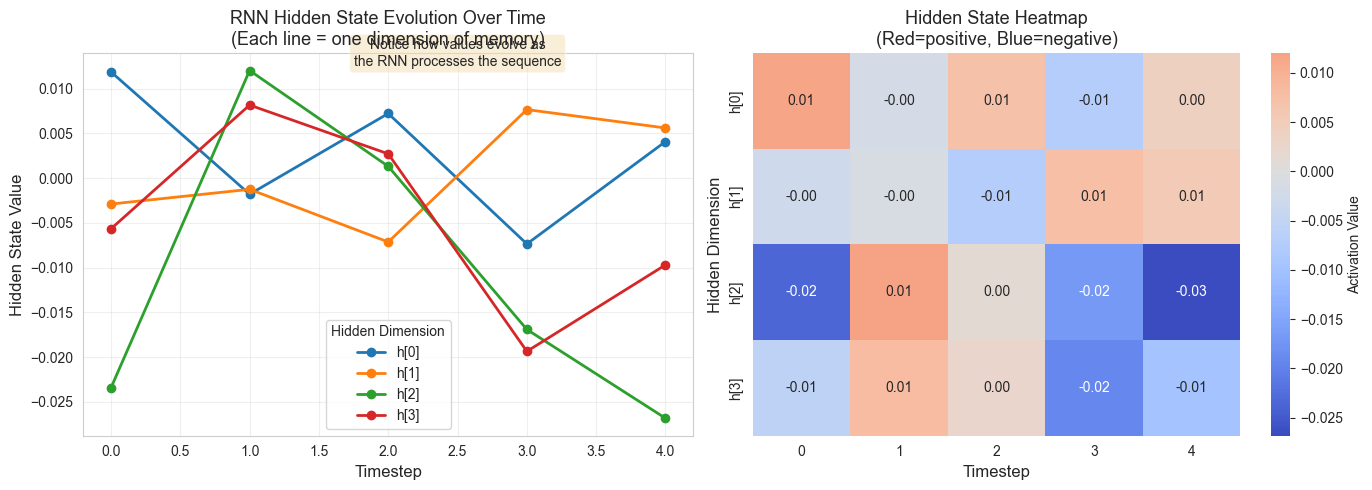

📊 What are we seeing?

The hidden state captures information from the ENTIRE sequence seen so far!

🔍 Key observations:
  • Each dimension (h[0], h[1], etc.) evolves differently
  • Values change at each timestep as new input arrives
  • The pattern shows how the RNN 'remembers' and updates its memory

🧠 Think of it like this:
  Each number in the hidden state is like a different 'note' on your notepad.
  As you read more words, you update your notes to remember what you've seen!


In [4]:
# Visualize how hidden states change over time
plt.figure(figsize=(14, 5))

# LEFT PLOT: Line plot showing each hidden dimension over time
plt.subplot(1, 2, 1)
plt.plot(hidden_states, linewidth=2, marker='o')
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Hidden State Value', fontsize=12)
plt.title('RNN Hidden State Evolution Over Time\n(Each line = one dimension of memory)', fontsize=13)
plt.legend([f'h[{i}]' for i in range(hidden_size)], 
          title='Hidden Dimension', loc='best')
plt.grid(True, alpha=0.3)

# Add annotations to help understand
plt.text(seq_len/2, plt.ylim()[1]*0.9, 
        'Notice how values evolve as\nthe RNN processes the sequence',
        ha='center', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# RIGHT PLOT: Heatmap showing all values at once
plt.subplot(1, 2, 2)
sns.heatmap(hidden_states.T,  # Transpose so dimensions are rows
           cmap='coolwarm',    # Red=positive, Blue=negative
           center=0,           # Center colormap at zero
           xticklabels=range(seq_len),
           yticklabels=[f'h[{i}]' for i in range(hidden_size)],
           cbar_kws={'label': 'Activation Value'},
           annot=True,         # Show numbers in cells
           fmt='.2f')          # Format numbers to 2 decimal places
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Hidden Dimension', fontsize=12)
plt.title('Hidden State Heatmap\n(Red=positive, Blue=negative)', fontsize=13)

plt.tight_layout()
plt.show()

print("📊 What are we seeing?")
print()
print("The hidden state captures information from the ENTIRE sequence seen so far!")
print()
print("🔍 Key observations:")
print("  • Each dimension (h[0], h[1], etc.) evolves differently")
print("  • Values change at each timestep as new input arrives")
print("  • The pattern shows how the RNN 'remembers' and updates its memory")
print()
print("🧠 Think of it like this:")
print("  Each number in the hidden state is like a different 'note' on your notepad.")
print("  As you read more words, you update your notes to remember what you've seen!")

## Part 3: The Vanishing Gradient Problem

RNNs have a **critical flaw**: they struggle to learn long-term dependencies. Let's understand why!

### The Problem (Simple Explanation)

Imagine you're training the RNN on this sentence:

```
"The cat, which was very fluffy and loved to sleep all day, was hungry"
 ↑                                                                ↑
word 1                                                        word 15

Task: Predict "was" at position 15 requires remembering "The cat" from position 1-2
```

**The RNN needs to learn**: "When I see 'hungry' at the end, I should remember seeing 'cat' at the start."

### How Learning Works: Backpropagation Through Time (BPTT)

To train the RNN, we use **backpropagation through time**:

```
Forward pass (left to right):
  word1 → word2 → word3 → ... → word15 → prediction → loss
  
Backward pass (right to left) - gradients flow backward:
  word1 ← word2 ← word3 ← ... ← word15 ← loss
  
The gradient must flow from word15 all the way back to word1!
```

### Why Gradients Vanish (Mathematical Explanation)

When gradients flow backward through time, at each timestep we multiply by:

```
∂h_t/∂h_{t-1} = W_hh × diag(tanh'(...))
```

Let's break down why this causes problems:

#### Problem 1: tanh derivative is small
```
tanh(x) squashes values to [-1, 1]
tanh'(x) = derivative of tanh

Key fact: tanh'(x) ≤ 1 for all x
In practice: tanh'(x) is usually around 0.1 to 0.5
```

#### Problem 2: Repeated multiplication
```
To flow gradient from timestep 15 to timestep 1:

gradient × W_hh × 0.5 ← at timestep 15
         × W_hh × 0.5 ← at timestep 14  
         × W_hh × 0.5 ← at timestep 13
         ...
         × W_hh × 0.5 ← at timestep 2
         
Total: gradient × (W_hh × 0.5)^14

If W_hh ≈ 0.5, then: (0.5 × 0.5)^14 ≈ 0.00006  (extremely small!)
```

#### Problem 3: Exponential decay
```
After 10 steps:  gradient ≈ original × 0.001
After 20 steps:  gradient ≈ original × 0.000001
After 50 steps:  gradient ≈ original × 0.0000000001 (basically zero!)
```

### The Consequence

**Gradient becomes too small → weights don't update → RNN can't learn long-term patterns!**

```
Example where RNN fails:

"The [30 words of irrelevant stuff] was delicious" → predict: "food"
     ↑                                                           ↑
  Important clue 30 words back                         Need to remember it here
  
❌ By the time we get to "delicious", the RNN has forgotten "food"!
```

**Practical limit**: Vanilla RNNs typically can only remember ~10-20 timesteps back.

### Demonstration: Vanishing Gradients in Action

Let's simulate how gradients change as they flow backward through time. This will show the **vanishing gradient problem** visually.

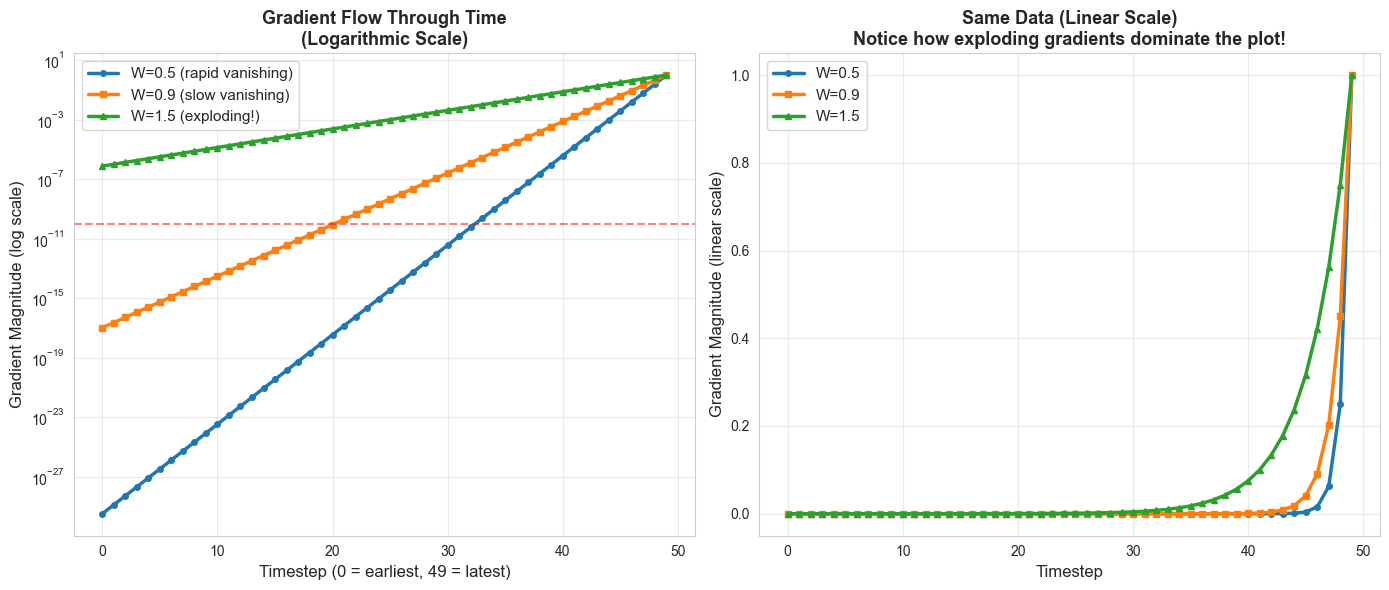

GRADIENT MAGNITUDE AFTER 50 TIMESTEPS:

  W=0.5 (small weight):   gradient = 3.16e-30
    → Essentially ZERO! Can't learn from early timesteps.

  W=0.9 (medium weight):  gradient = 1.02e-17
    → Still very small, but not quite zero.

  W=1.5 (large weight):   gradient = 7.55e-07
    → EXPLODED! Training will be unstable.

KEY INSIGHT:

There's a narrow range of weight values that work:
  • Too small → gradients vanish → can't learn long-term dependencies
  • Too large → gradients explode → training becomes unstable
  • This is why vanilla RNNs are SO HARD to train!

This problem motivated the invention of LSTMs (which we'll see next!)


In [5]:
def simulate_gradient_flow(seq_len=50, weight_value=0.9):
    """
    Simulate how gradients change as they flow backward through time in an RNN.
    
    This is a simplified model that shows the core problem:
    - We start with a gradient of 1.0 at the final timestep
    - Each timestep backward, we multiply by:
        - weight_value (representing W_hh)
        - tanh_derivative (approximately 0.5 on average)
    
    Args:
        seq_len: Length of sequence (number of timesteps)
        weight_value: Value of recurrent weight W_hh
    
    Returns:
        Array of gradient values at each timestep
    """
    # Start with gradient = 1.0 at the final timestep
    # (This is like: "how much does the loss change with respect to the final hidden state?")
    gradient = 1.0
    gradients = [gradient]
    
    # Average derivative of tanh is approximately 0.5
    # (tanh'(x) ranges from 0 to 1, typically around 0.5)
    tanh_derivative = 0.5
    
    # Simulate gradient flowing backward through time
    for t in range(seq_len - 1):
        # At each timestep, gradient gets multiplied by:
        # - The weight value (W_hh)
        # - The activation derivative (tanh')
        # This is a simplification of: ∂h_t/∂h_{t-1} = W_hh × tanh'(...)
        gradient = gradient * weight_value * tanh_derivative
        gradients.append(gradient)
    
    # Reverse the list so gradients[0] = timestep 0, gradients[-1] = final timestep
    return np.array(gradients[::-1])

# Simulate three different scenarios
seq_len = 50  # 50 timesteps (not too long in practice!)

# Scenario 1: Small weights (W_hh = 0.5)
# This will cause RAPID vanishing
gradients_small_weight = simulate_gradient_flow(seq_len, weight_value=0.5)

# Scenario 2: Medium weights (W_hh = 0.9)  
# This will cause SLOW vanishing (but still vanishes!)
gradients_medium_weight = simulate_gradient_flow(seq_len, weight_value=0.9)

# Scenario 3: Large weights (W_hh = 1.5)
# This will cause EXPLODING gradients (opposite problem!)
gradients_large_weight = simulate_gradient_flow(seq_len, weight_value=1.5)

# ===== PLOT THE RESULTS =====
plt.figure(figsize=(14, 6))

# LEFT PLOT: Logarithmic scale (shows vanishing more clearly)
plt.subplot(1, 2, 1)
plt.semilogy(gradients_small_weight, label='W=0.5 (rapid vanishing)', linewidth=2.5, marker='o', markersize=4)
plt.semilogy(gradients_medium_weight, label='W=0.9 (slow vanishing)', linewidth=2.5, marker='s', markersize=4)
plt.semilogy(gradients_large_weight, label='W=1.5 (exploding!)', linewidth=2.5, marker='^', markersize=4)
plt.xlabel('Timestep (0 = earliest, 49 = latest)', fontsize=12)
plt.ylabel('Gradient Magnitude (log scale)', fontsize=12)
plt.title('Gradient Flow Through Time\n(Logarithmic Scale)', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.4, which='both')
plt.axhline(y=1e-10, color='r', linestyle='--', alpha=0.5, label='Essentially zero')

# RIGHT PLOT: Linear scale (shows absolute values)
plt.subplot(1, 2, 2)
plt.plot(gradients_small_weight, label='W=0.5', linewidth=2.5, marker='o', markersize=4)
plt.plot(gradients_medium_weight, label='W=0.9', linewidth=2.5, marker='s', markersize=4)
plt.plot(gradients_large_weight, label='W=1.5', linewidth=2.5, marker='^', markersize=4)
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Gradient Magnitude (linear scale)', fontsize=12)
plt.title('Same Data (Linear Scale)\nNotice how exploding gradients dominate the plot!', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

# Print numerical results
print("=" * 70)
print("GRADIENT MAGNITUDE AFTER 50 TIMESTEPS:")
print("=" * 70)
print()
print(f"  W=0.5 (small weight):   gradient = {gradients_small_weight[0]:.2e}")
print(f"    → Essentially ZERO! Can't learn from early timesteps.")
print()
print(f"  W=0.9 (medium weight):  gradient = {gradients_medium_weight[0]:.2e}")
print(f"    → Still very small, but not quite zero.")
print()
print(f"  W=1.5 (large weight):   gradient = {gradients_large_weight[0]:.2e}")
print(f"    → EXPLODED! Training will be unstable.")
print()
print("=" * 70)
print("KEY INSIGHT:")
print("=" * 70)
print()
print("There's a narrow range of weight values that work:")
print("  • Too small → gradients vanish → can't learn long-term dependencies")
print("  • Too large → gradients explode → training becomes unstable")
print("  • This is why vanilla RNNs are SO HARD to train!")
print()
print("This problem motivated the invention of LSTMs (which we'll see next!)")

### Key Takeaway: Why This Matters

The vanishing gradient problem is **THE fundamental limitation** of vanilla RNNs:

1. **Short memory**: Can only remember ~10-20 timesteps
2. **Hard to train**: Very sensitive to initialization and hyperparameters
3. **Fails on long sequences**: Can't learn dependencies like "The cat ... was hungry" if there are many words in between

This is exactly the problem that **LSTMs** were designed to solve! Let's see how...

## Part 4: LSTMs - A Partial Solution

**Long Short-Term Memory (LSTM)** networks, introduced in 1997 by Hochreiter & Schmidhuber, partially solve the vanishing gradient problem.

### The Big Idea (Simple Explanation)

**Problem with RNNs**: Information gets "diluted" as it flows through time.

**LSTM Solution**: Create a special "highway" for information to flow through unchanged!

Think of it like this:

```
Regular RNN:
  Info → transform → transform → transform → ... → (info is distorted)
  
LSTM:
  Info → highway (unchanged) → highway → highway → ... → (info preserved!)
         ↓                     ↓           ↓
      Gates control what travels on the highway
```

### LSTM Components

Instead of just a hidden state `h_t`, LSTMs have TWO states:

1. **Cell state `C_t`** - The "highway" / "conveyor belt"
   - Carries information through time with minimal changes
   - Think: A long-term memory that can preserve information
   
2. **Hidden state `h_t`** - The output (like in regular RNN)
   - What the LSTM outputs at each timestep
   - Think: Short-term working memory

### The Three Gates

LSTMs use **gates** to control information flow. Think of gates like on/off switches:

#### Gate 1: Forget Gate
```
"What should I forget from my long-term memory?"

Values close to 0: Forget this information
Values close to 1: Keep this information

Example: Reading "The cat was hungry. The dog..."
  → When you see "dog", forget gate might say: "Forget about the cat!"
```

#### Gate 2: Input Gate
```
"What new information should I add to my long-term memory?"

Values close to 0: Don't add this new info
Values close to 1: Add this new info

Example: Reading "The dog was happy"
  → Input gate might say: "Remember that it's a dog!"
```

#### Gate 3: Output Gate
```
"What should I output based on my long-term memory?"

Values close to 0: Don't output this
Values close to 1: Output this

Example: Predicting next word after "The dog was"
  → Output gate decides what aspects of memory are relevant for prediction
```

### LSTM Equations (Detailed Explanation)

Don't worry if these look complex - we'll break them down!

```python
# 1. Forget gate: What to forget from cell state
f_t = sigmoid(W_f @ [h_{t-1}, x_t] + b_f)

# 2. Input gate: What to add to cell state
i_t = sigmoid(W_i @ [h_{t-1}, x_t] + b_i)
C_tilde = tanh(W_C @ [h_{t-1}, x_t] + b_C)  # Candidate values to add

# 3. Update cell state (THE KEY STEP!)
C_t = f_t * C_{t-1} + i_t * C_tilde
#     ^^^^^^^^^^^^   ^^^^^^^^^^^^^^
#     Keep old info  Add new info

# 4. Output gate: What to output
o_t = sigmoid(W_o @ [h_{t-1}, x_t] + b_o)
h_t = o_t * tanh(C_t)
```

### Why LSTMs Solve Vanishing Gradients

Look at the cell state update equation:

```
C_t = f_t * C_{t-1} + i_t * C_tilde
      ^^^^^^^^^^^^^
      This is ADDITION, not multiplication!
```

**Key insight**:
- In RNN: `h_t = tanh(W @ h_{t-1} + ...)` → lots of multiplications
- In LSTM: `C_t = f_t * C_{t-1} + ...` → addition creates a direct path!

Gradients can flow through the **addition** without vanishing as quickly!

```
Gradient flow in RNN:
  ∇ × W × W × W × W × ... (multiplied many times → vanishes)
  
Gradient flow in LSTM:
  ∇ flows through additions in cell state → much more stable!
```

### LSTM Implementation (Simplified)

Let's implement a single LSTM cell to understand exactly how the gates work!

In [6]:
def sigmoid(x):
    """
    Sigmoid activation function.
    
    Maps any number to range (0, 1)
    Perfect for gates because:
      - 0 means "completely close this gate"
      - 1 means "completely open this gate"
      - 0.5 means "half open"
    """
    return 1 / (1 + np.exp(-x))

class LSTMCell:
    """
    Single LSTM cell (processes one timestep).
    
    This implements the full LSTM equations with forget, input, and output gates.
    """
    
    def __init__(self, input_size, hidden_size):
        """
        Initialize LSTM cell with random weights.
        
        Args:
            input_size: Dimension of input x_t
            hidden_size: Dimension of hidden state h_t and cell state C_t
        """
        self.hidden_size = hidden_size
        
        # We concatenate [h_{t-1}, x_t] and use one weight matrix for efficiency
        # This is a common implementation trick
        combined_size = hidden_size + input_size
        
        # Weight matrices for the four components (3 gates + cell candidate)
        # Each has shape (combined_size, hidden_size)
        self.W_f = np.random.randn(combined_size, hidden_size) * 0.01  # Forget gate
        self.W_i = np.random.randn(combined_size, hidden_size) * 0.01  # Input gate
        self.W_C = np.random.randn(combined_size, hidden_size) * 0.01  # Cell candidate
        self.W_o = np.random.randn(combined_size, hidden_size) * 0.01  # Output gate
        
        # Bias vectors
        self.b_f = np.zeros(hidden_size)
        self.b_i = np.zeros(hidden_size)
        self.b_C = np.zeros(hidden_size)
        self.b_o = np.zeros(hidden_size)
    
    def forward(self, x_t, h_prev, C_prev):
        """
        Forward pass for one timestep.
        
        Args:
            x_t: Input at time t, shape (input_size,)
            h_prev: Previous hidden state h_{t-1}, shape (hidden_size,)
            C_prev: Previous cell state C_{t-1}, shape (hidden_size,)
        
        Returns:
            h_t: New hidden state
            C_t: New cell state
            (f_t, i_t, o_t): Gate values (for visualization)
        """
        # ===== STEP 1: CONCATENATE h_{t-1} and x_t =====
        # Combine previous hidden state and current input into one vector
        # This gives the gates access to both "what I saw before" and "what I see now"
        combined = np.concatenate([h_prev, x_t])
        # combined shape: (hidden_size + input_size,)
        
        # ===== STEP 2: FORGET GATE =====
        # Decide what to forget from the cell state C_{t-1}
        # f_t is a vector of values in range [0, 1]
        #   f_t[i] = 1 means "keep dimension i of cell state"
        #   f_t[i] = 0 means "forget dimension i of cell state"
        f_t = sigmoid(combined @ self.W_f + self.b_f)
        
        # ===== STEP 3: INPUT GATE =====
        # Decide what new information to add to cell state
        
        # Part 3a: Input gate (controls how much to add)
        # i_t is a vector of values in range [0, 1]
        i_t = sigmoid(combined @ self.W_i + self.b_i)
        
        # Part 3b: Candidate cell state (what we might add)
        # C_tilde is a vector of values in range [-1, 1] (thanks to tanh)
        # These are the "proposed" new values
        C_tilde = np.tanh(combined @ self.W_C + self.b_C)
        
        # ===== STEP 4: UPDATE CELL STATE (THE MAGIC HAPPENS HERE!) =====
        # This is THE equation that solves vanishing gradients!
        C_t = f_t * C_prev + i_t * C_tilde
        #     ^^^^^^^^^^^^   ^^^^^^^^^^^^^^
        #     What to keep   What to add
        #
        # Element-wise breakdown:
        #   - f_t * C_prev: Keep old information (scaled by forget gate)
        #   - i_t * C_tilde: Add new information (scaled by input gate)
        #   - Addition creates a "highway" for gradients to flow!
        
        # ===== STEP 5: OUTPUT GATE =====
        # Decide what to output based on cell state
        # o_t is a vector of values in range [0, 1]
        o_t = sigmoid(combined @ self.W_o + self.b_o)
        
        # ===== STEP 6: COMPUTE HIDDEN STATE =====
        # The hidden state is a filtered version of the cell state
        # tanh(C_t) squashes cell state to [-1, 1]
        # o_t controls what parts of cell state to output
        h_t = o_t * np.tanh(C_t)
        
        # Return new states and gate values (gates are useful for visualization!)
        return h_t, C_t, (f_t, i_t, o_t)

# ===== TEST THE LSTM CELL =====

print("=" * 70)
print("Creating and testing LSTM cell...")
print("=" * 70)

# Create LSTM cell
lstm = LSTMCell(input_size=3, hidden_size=4)

# Initialize states (start with zeros)
h = np.zeros(4)  # Initial hidden state
C = np.zeros(4)  # Initial cell state
x = np.random.randn(3)  # Random input

# Run one forward pass
h_new, C_new, gates = lstm.forward(x, h, C)

print("\n📊 Input and Output Shapes:")
print(f"  Input x shape:        {x.shape}")
print(f"  Hidden state h shape: {h_new.shape}")
print(f"  Cell state C shape:   {C_new.shape}")

print("\n🚪 Gate Values (range 0-1):")
print(f"  Forget gate f_t: {gates[0][:2]}... (showing first 2 dimensions)")
print(f"    → Values close to 1 mean 'keep old memory'")
print(f"    → Values close to 0 mean 'forget old memory'")
print()
print(f"  Input gate i_t:  {gates[1][:2]}... (showing first 2 dimensions)")
print(f"    → Values close to 1 mean 'accept new info'")
print(f"    → Values close to 0 mean 'ignore new info'")
print()
print(f"  Output gate o_t: {gates[2][:2]}... (showing first 2 dimensions)")
print(f"    → Values close to 1 mean 'output this'")
print(f"    → Values close to 0 mean 'don't output this'")

print("\n✓ LSTM cell works correctly!")
print("\n💡 Key takeaway: The gates are automatically learning what to")
print("   remember, forget, and output based on the input and previous state!")

Creating and testing LSTM cell...

📊 Input and Output Shapes:
  Input x shape:        (3,)
  Hidden state h shape: (4,)
  Cell state C shape:   (4,)

🚪 Gate Values (range 0-1):
  Forget gate f_t: [0.50249346 0.49926157]... (showing first 2 dimensions)
    → Values close to 1 mean 'keep old memory'
    → Values close to 0 mean 'forget old memory'

  Input gate i_t:  [0.5016098  0.49581727]... (showing first 2 dimensions)
    → Values close to 1 mean 'accept new info'
    → Values close to 0 mean 'ignore new info'

  Output gate o_t: [0.49824626 0.50488284]... (showing first 2 dimensions)
    → Values close to 1 mean 'output this'
    → Values close to 0 mean 'don't output this'

✓ LSTM cell works correctly!

💡 Key takeaway: The gates are automatically learning what to
   remember, forget, and output based on the input and previous state!


### Visualizing LSTM Gates

Let's process a sequence and see how the gates behave over time. This will show you **how LSTMs control information flow**!

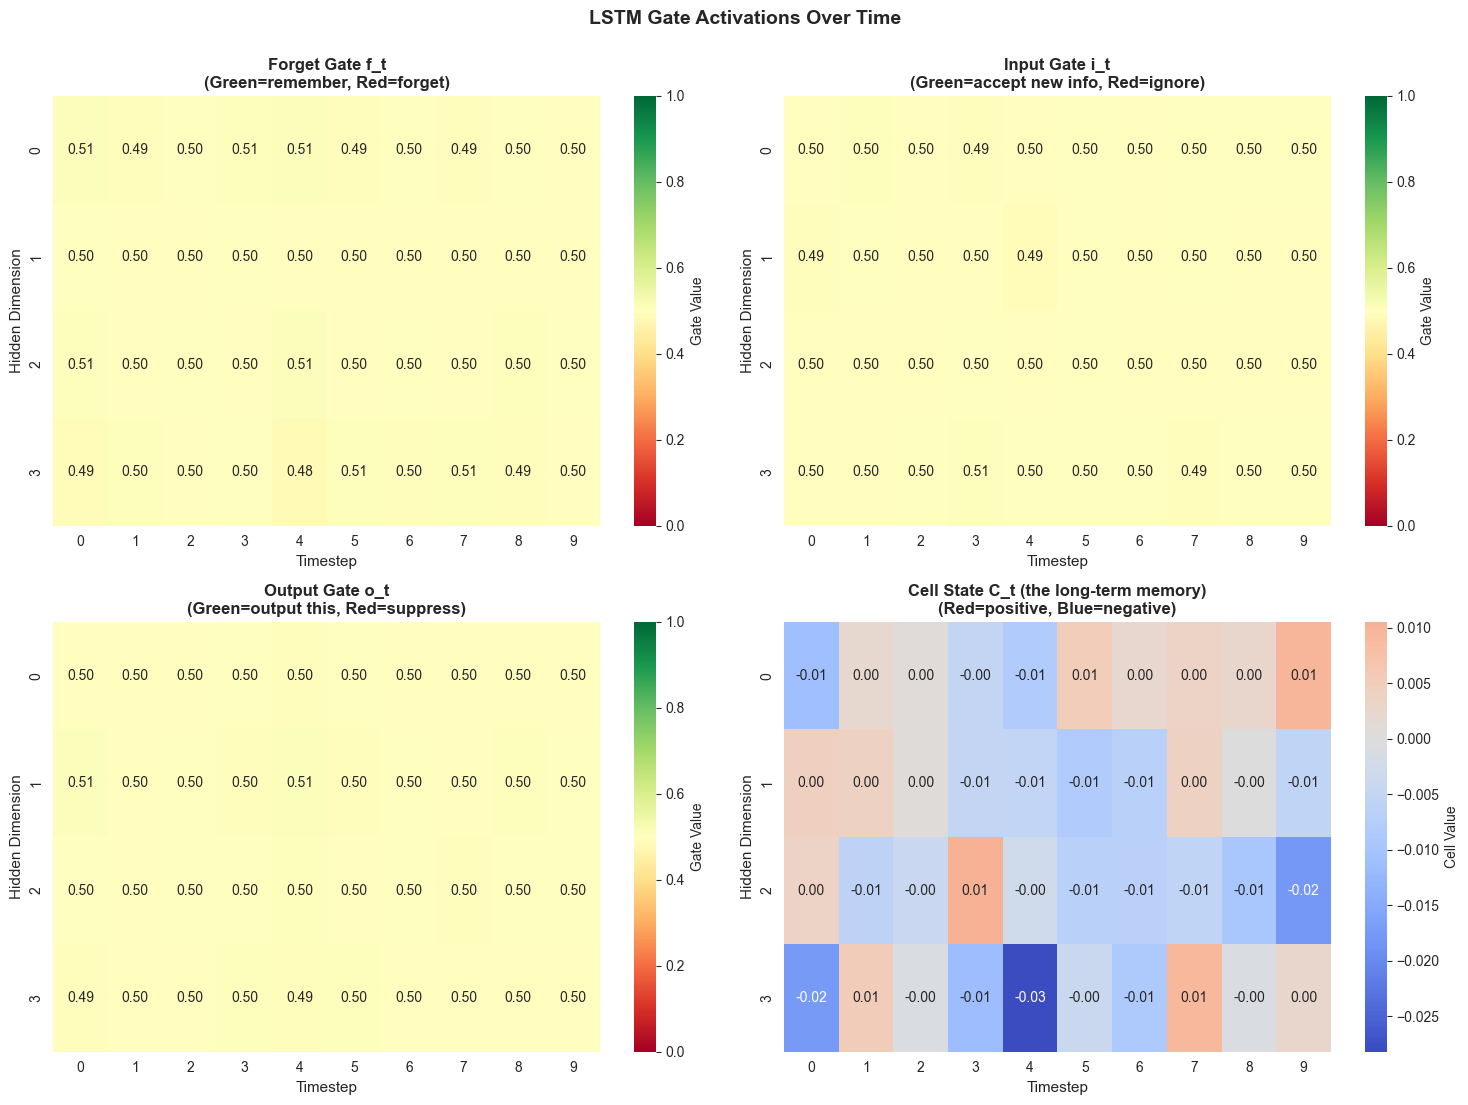

📊 What are we seeing in these heatmaps?

Each heatmap shows how that gate/state evolves over time:

🚪 GATE INTERPRETATION:
  • Green (close to 1.0) = 'Allow information through'
  • Red (close to 0.0)   = 'Block information'
  • Yellow (around 0.5)  = 'Partially allow'

📝 CELL STATE:
  • Red (positive)  = Positive activation
  • Blue (negative) = Negative activation
  • This is where the LSTM stores its long-term memory!

🧠 KEY INSIGHT:
  The gates are dynamically controlling what information:
    1. Gets forgotten (forget gate)
    2. Gets added (input gate)
    3. Gets output (output gate)

  This selective control is what allows LSTMs to maintain long-term
  dependencies better than vanilla RNNs!


In [7]:
# Process a sequence and track gate activations over time
seq_len = 10
inputs = np.random.randn(seq_len, 3)  # Random sequence of 10 timesteps

# Initialize states
h = np.zeros(4)
C = np.zeros(4)

# Storage for tracking everything
forget_gates = []  # Will store forget gate values at each timestep
input_gates = []   # Will store input gate values
output_gates = []  # Will store output gate values
cell_states = []   # Will store cell state values

# Process the sequence one timestep at a time
for t in range(seq_len):
    # Run LSTM forward pass
    h, C, gates = lstm.forward(inputs[t], h, C)
    
    # Extract gate values
    f_t, i_t, o_t = gates
    
    # Save for visualization
    forget_gates.append(f_t)
    input_gates.append(i_t)
    output_gates.append(o_t)
    cell_states.append(C.copy())

# Convert to numpy arrays for easier plotting
forget_gates = np.array(forget_gates)  # Shape: (seq_len, hidden_size)
input_gates = np.array(input_gates)
output_gates = np.array(output_gates)
cell_states = np.array(cell_states)

# ===== CREATE VISUALIZATION =====
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# PLOT 1: Forget Gate
sns.heatmap(forget_gates.T,  # Transpose so dimensions are rows
           ax=axes[0, 0],
           cmap='RdYlGn',     # Red=forget, Yellow=middle, Green=remember
           vmin=0, vmax=1,    # Gate values are always in [0, 1]
           xticklabels=range(seq_len),
           yticklabels=range(4),
           cbar_kws={'label': 'Gate Value'},
           annot=True,        # Show values in cells
           fmt='.2f')         # 2 decimal places
axes[0, 0].set_title('Forget Gate f_t\n(Green=remember, Red=forget)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Timestep', fontsize=11)
axes[0, 0].set_ylabel('Hidden Dimension', fontsize=11)

# PLOT 2: Input Gate
sns.heatmap(input_gates.T,
           ax=axes[0, 1],
           cmap='RdYlGn',     # Red=ignore new, Green=accept new
           vmin=0, vmax=1,
           xticklabels=range(seq_len),
           yticklabels=range(4),
           cbar_kws={'label': 'Gate Value'},
           annot=True,
           fmt='.2f')
axes[0, 1].set_title('Input Gate i_t\n(Green=accept new info, Red=ignore)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Timestep', fontsize=11)
axes[0, 1].set_ylabel('Hidden Dimension', fontsize=11)

# PLOT 3: Output Gate
sns.heatmap(output_gates.T,
           ax=axes[1, 0],
           cmap='RdYlGn',     # Red=don't output, Green=do output
           vmin=0, vmax=1,
           xticklabels=range(seq_len),
           yticklabels=range(4),
           cbar_kws={'label': 'Gate Value'},
           annot=True,
           fmt='.2f')
axes[1, 0].set_title('Output Gate o_t\n(Green=output this, Red=suppress)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Timestep', fontsize=11)
axes[1, 0].set_ylabel('Hidden Dimension', fontsize=11)

# PLOT 4: Cell State (the actual memory!)
sns.heatmap(cell_states.T,
           ax=axes[1, 1],
           cmap='coolwarm',   # Blue=negative, Red=positive
           center=0,          # Center color at zero
           xticklabels=range(seq_len),
           yticklabels=range(4),
           cbar_kws={'label': 'Cell Value'},
           annot=True,
           fmt='.2f')
axes[1, 1].set_title('Cell State C_t (the long-term memory)\n(Red=positive, Blue=negative)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Timestep', fontsize=11)
axes[1, 1].set_ylabel('Hidden Dimension', fontsize=11)

plt.suptitle('LSTM Gate Activations Over Time', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("=" * 70)
print("📊 What are we seeing in these heatmaps?")
print("=" * 70)
print()
print("Each heatmap shows how that gate/state evolves over time:")
print()
print("🚪 GATE INTERPRETATION:")
print("  • Green (close to 1.0) = 'Allow information through'")
print("  • Red (close to 0.0)   = 'Block information'")
print("  • Yellow (around 0.5)  = 'Partially allow'")
print()
print("📝 CELL STATE:")
print("  • Red (positive)  = Positive activation")
print("  • Blue (negative) = Negative activation")
print("  • This is where the LSTM stores its long-term memory!")
print()
print("🧠 KEY INSIGHT:")
print("  The gates are dynamically controlling what information:")
print("    1. Gets forgotten (forget gate)")
print("    2. Gets added (input gate)")
print("    3. Gets output (output gate)")
print()
print("  This selective control is what allows LSTMs to maintain long-term")
print("  dependencies better than vanilla RNNs!")

## Part 5: Seq2Seq Models

**Sequence-to-Sequence (Seq2Seq)** models use RNNs/LSTMs for tasks like machine translation, summarization, and conversational AI.

### The Architecture (Simple Explanation)

A Seq2Seq model has **two parts**:

```
INPUT:  "Hello how are you"
         ↓
ENCODER: [LSTM] processes English sentence
         ↓
    context vector (fixed-size summary)
         ↓
DECODER: [LSTM] generates French translation
         ↓
OUTPUT: "Bonjour comment allez-vous"
```

### Detailed Explanation

#### Step 1: Encoder
```
The encoder reads the input sequence word by word:

"Hello" → [LSTM] → h_1
"how"   → [LSTM] → h_2
"are"   → [LSTM] → h_3
"you"   → [LSTM] → h_4 (final hidden state)

The final hidden state h_4 is the "context vector"
It's supposed to capture the ENTIRE meaning of the input!
```

#### Step 2: Decoder
```
The decoder uses the context vector to generate output:

context → [LSTM] → predict "Bonjour"
"Bonjour" → [LSTM] → predict "comment"
"comment" → [LSTM] → predict "allez-vous"
"allez-vous" → [LSTM] → predict <END>
```

### The Critical Problem: Information Bottleneck

Here's the issue: **The entire input must be compressed into a single fixed-size vector!**

```
Short sentence (easy):
"Hello" → context vector (512 numbers) → "Bonjour"
✓ Plenty of capacity to encode the meaning!

Long sentence (hard):
"The quick brown fox jumps over the lazy dog near the river..." (100 words)
    ↓
context vector (still only 512 numbers!)
    ↓
French translation
❌ Not enough capacity! Information is lost!
```

### Why This is a Problem

1. **Information loss**: Long sentences can't fit into fixed-size vector
2. **Performance degrades**: Translation quality drops for long sentences
3. **Early information forgotten**: By the time encoder reaches word 100, it has forgotten word 1!

### Real-World Example

```
Input: "The cat, which was very fluffy and loved to sleep all day long
        and was sitting on the mat that I bought from the store yesterday,
        was hungry."

Problem: By the time we reach "was hungry", the encoder has processed
so many words that "cat" might be lost from the context vector!

Result: The translation might lose track of what subject the sentence is about.
```

### The Solution?

This information bottleneck problem is exactly what motivated the **attention mechanism**!

Instead of compressing everything into one vector, attention allows the decoder to **look at all encoder hidden states** and focus on the relevant parts.

We'll learn about attention in the next notebook!

## Part 6: Why We Needed Transformers

Let's summarize all the **fundamental limitations** of RNN-based models. This will set the stage for understanding why transformers were such a breakthrough!

### Problem 1: Sequential Processing (Speed Issue)

```
RNN must process words ONE AT A TIME:
  word1 → wait → word2 → wait → word3 → wait → ...
  (sequential, can't parallelize!)
```

**Why this is bad:**
- **Slow**: Must process 100 words sequentially for a 100-word sentence
- **Can't use GPU effectively**: Modern GPUs are great at parallel operations, but RNNs force sequential processing
- **Training takes forever**: On large datasets, this is a huge bottleneck

**Analogy**: Imagine reading a book where you must finish page 1 before starting page 2, finish page 2 before starting page 3, etc. You can't read multiple pages in parallel!

### Problem 2: Long-Range Dependencies (Memory Issue)

```
"The cat, which was sitting on the mat that I bought yesterday, meowed loudly."
 ↑                                                                ↑
word 1                                                        word 13

To connect "cat" with "meowed", information must flow through 12 timesteps!
```

**Why this is bad:**
- **LSTMs help but don't fully solve**: Information still degrades
- **Performance drops with distance**: The farther apart two words are, the harder to learn their relationship
- **Real-world sentences can be very long**: 50-100 words is common!

**Analogy**: Playing a game of telephone where the message gets corrupted at each step.

### Problem 3: Fixed Context Vector (Seq2Seq Bottleneck)

```
100-word sentence → [compress] → 512-number vector → [decompress] → translation
                                      ↑
                         This is too small!
```

**Why this is bad:**
- **Information loss**: Can't fit 100 words' worth of information into a fixed-size vector
- **Quality degrades with length**: Longer inputs = worse compression = worse outputs
- **No flexibility**: Same vector size for "Hello" and for a paragraph

**Analogy**: Trying to summarize "War and Peace" (1200 pages) in a single tweet (280 characters).

### Problem 4: No Direct Access (Information Flow Issue)

```
When processing word 10, to access information from word 3:
  word3 → word4 → word5 → ... → word10
  (information degrades through this chain)

Can't just "look back" at word 3 directly!
```

**Why this is bad:**
- **Indirect access**: Must go through intermediate steps
- **Information degradation**: Message gets corrupted along the way
- **Harder to learn**: Gradients must flow through all intermediate steps

**Analogy**: In a meeting, instead of directly asking someone a question, you have to pass a note through 10 other people first!

### What We Really Want

An ideal architecture should:

1. ✅ **Process sequences in parallel** (use GPUs effectively, train faster)
2. ✅ **Handle arbitrary long-range dependencies** (connect word 1 to word 100 easily)
3. ✅ **Direct access to any part of input** (no information bottleneck)
4. ✅ **Scale to long sequences** (no degradation with length)

### The Transformer Solution (2017)

**Transformers solved ALL of these problems using "attention"!**

```
Key insight: Self-Attention

Instead of:
  word1 → word2 → word3 → ... (sequential)

Transformers do:
  word1 ←→ word2 ←→ word3 ←→ ... (every word looks at every other word!)
```

**How this solves the problems:**

1. **Parallel processing**: All words processed simultaneously! ✓
2. **Long-range dependencies**: Word 1 directly connects to word 100! ✓
3. **No bottleneck**: Each word can attend to all other words! ✓
4. **Direct access**: No information degradation through intermediate steps! ✓

In the next notebook, we'll dive deep into **how attention works** and implement it from scratch!

## Summary: What We Learned

Let's recap everything we covered in this notebook:

### 1. Vanilla RNNs
```
✅ Can process variable-length sequences
✅ Have memory through hidden state h_t
❌ Vanishing gradient problem (can't learn long-term dependencies)
❌ Sequential processing (slow, can't parallelize)
❌ Typical memory span: ~10-20 timesteps
```

**Key equation**: `h_t = tanh(W_hh @ h_{t-1} + W_xh @ x_t + b_h)`

### 2. LSTMs
```
✅ Better at long-range dependencies (vs vanilla RNN)
✅ Gates control information flow intelligently
✅ Cell state provides "highway" for gradients
✅ Can handle ~50-100 timesteps (much better than RNN)
❌ Still struggle with very long sequences (500+ timesteps)
❌ Still sequential (can't parallelize)
```

**Key innovation**: Addition in cell state update prevents gradient vanishing!

### 3. Seq2Seq Models
```
✅ Enabled translation and generation tasks
✅ Encoder-decoder architecture is powerful
❌ Information bottleneck (fixed context vector)
❌ Performance degrades with input length
❌ Long inputs can't fit in fixed-size vector
```

**Architecture**: Encoder (compress input) → Context Vector → Decoder (generate output)

### 4. Why We Needed Transformers

All RNN-based models share these fundamental limitations:
1. Sequential processing (slow)
2. Limited long-range dependencies
3. Information bottleneck
4. No direct access to distant words

**Transformers (2017) solved all of these using self-attention!**

### The Stage is Set!

Now you understand:
- ✅ What problems sequence models need to solve
- ✅ How RNNs and LSTMs work
- ✅ Why they have limitations
- ✅ What motivated the transformer architecture

In the next notebook, we'll learn about **the attention mechanism** that makes transformers work!

```
Preview of next notebook:
  • What is attention?
  • How does attention solve the problems we identified?
  • Implementing attention from scratch
  • Understanding "Attention Is All You Need"
```

## Exercises

Before moving to the next notebook, try these exercises to deepen your understanding:

### 1. Experiment with RNN
**Task**: Modify the `SimpleRNN` class and observe the effects.

Try:
- Change `hidden_size` to 2, 8, 16. How do the hidden state visualizations change?
- Replace `tanh` with `ReLU` (`np.maximum(0, x)`). What happens? Why might this be bad?
- Process a longer sequence (seq_len=20). How do hidden states evolve?

### 2. Understand Vanishing Gradients
**Task**: Play with the gradient simulation.

Questions:
- What weight value keeps gradients stable longest?
- Try seq_len=100. Do gradients vanish faster?
- Why is it hard to find a weight value that avoids both vanishing AND exploding?

### 3. Interpret LSTM Gates
**Task**: Look at the gate visualizations and answer:

- Which gate values (0 or 1) indicate "remembering" information?
- Which indicate "forgetting"?
- How might gate patterns differ for:
  - A sequence that requires long-term memory?
  - A sequence where you want to quickly forget old information?

### 4. Think Ahead to Transformers
**Task**: Before seeing the next notebook, brainstorm:

- How could we give a model "direct access" to all inputs at once?
- How might we process an entire sequence in parallel?
- Sketch your ideas on paper!

### 5. Code Challenge (Advanced)
**Task**: Implement a simple character-level language model.

```python
# Train an RNN to predict the next character
# Given: "hell" → predict: "o"
# Given: "hello worl" → predict: "d"
```

Hints:
- Use the `SimpleRNN` class we built
- Start with a very short text ("hello world")
- One-hot encode characters
- See how well it learns!

## Next Steps

**Congratulations!** You now have a solid understanding of the pre-transformer era!

### What's Next?

In the next notebook (`02_attention_mechanism.ipynb`), we'll learn about:

1. **The attention mechanism** - The key innovation that changed everything
2. **How attention solves** the problems we identified in this notebook
3. **Implementing attention from scratch** - Build it yourself in NumPy!
4. **Why "Attention Is All You Need"** - Understanding the paper that started it all

### Key Questions We'll Answer

- How does a word "attend to" other words?
- What are Query, Key, and Value?
- How does attention enable parallel processing?
- How does attention eliminate the information bottleneck?

### Preparation

Make sure you understand:
- ✅ RNN equations and how hidden states work
- ✅ Why RNNs have vanishing gradients
- ✅ How LSTM gates control information flow
- ✅ The seq2seq information bottleneck problem

If any of these are unclear, review the relevant sections above!

**This is where the magic begins!** 🚀

The attention mechanism will completely change how we think about sequence modeling, and it's the foundation of **every modern LLM** including GPT, BERT, and beyond!